# DTG neutron source light analysis

In [1]:
import h5py
import numpy as np
import h5flow
import matplotlib.pyplot as plt
from matplotlib import cm, colors

In [2]:
def thd_correct(array):

    # Define start and end indices
    indices = np.arange(0, 41) * 25  # (39,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (39,)

    segment_range = np.arange(25)  # Shape: (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (39, 25)

    # Extract data using advanced indexing
    sliced_data = array[..., index_array]
    
    ranges = np.ptp(sliced_data, axis=-1)  # Compute range (n, 8, 64, 39)
    means = np.mean(sliced_data, axis=-1)  # Compute mean (n, 8, 64, 39)

    # Find ordering based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (n, 8, 64, 39)

    # Sort means using the ordering
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (n, 8, 64, 39)
    sorted_range = np.take_along_axis(ranges, smallest_ordering, axis=-1)
    # Compute average of 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:4], axis=-1)  # Shape (n, 8, 64)
    expanded_mean = average_mean[..., None] 
    broadcasted_mean = np.tile(expanded_mean, (1, 1000))  
    filtered_wvfm = array - broadcasted_mean

    return filtered_wvfm

In [39]:
path = '/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/DTG_prod_v3/FLOW/2x2_MyQGSP_BERT_ArHP_PNS_DTG_prod_v3_22.FLOW.hdf5'
file = h5flow.data.H5FlowDataManager(path, "r")

In [40]:
keys = h5py.File(path, 'r').keys()
print('keys: ', keys)
for k in keys:
    sub_keys = print('subkeys: ', h5py.File(path, 'r')[k].keys())

keys:  <KeysViewHDF5 ['charge', 'combined', 'geometry_info', 'lar_info', 'light', 'mc_truth', 'run_info']>
subkeys:  <KeysViewHDF5 ['calib_final_hits', 'calib_prompt_hits', 'events', 'ext_trigs', 'packets', 'packets_corr_ts', 'raw_events', 'raw_hits']>
subkeys:  <KeysViewHDF5 ['t0']>
subkeys:  <KeysViewHDF5 ['anode_drift_coordinate', 'det_bounds', 'det_id', 'det_rel_pos', 'det_type', 'disabled_channels', 'disabled_chips', 'drift_dir', 'pixel_coordinates_2D', 'sipm_abs_pos', 'sipm_rel_pos', 'tile_id']>
subkeys:  <KeysViewHDF5 []>
subkeys:  <KeysViewHDF5 ['cwvfm', 'events', 'flash', 'sipm_hits', 'stpc_wvfm', 'sum_hits', 'sum_tpc_hits', 'swvfm', 't_ns', 'wvfm']>
subkeys:  <KeysViewHDF5 ['calib_final_hit_backtrack', 'calib_prompt_hit_backtrack', 'interactions', 'light', 'packet_fraction', 'segments', 'trajectories']>
subkeys:  <KeysViewHDF5 []>


In [41]:
file['charge/calib_final_hits/data'].dtype.names

('id',
 'x',
 'y',
 'z',
 't_drift',
 'ts_pps',
 'io_group',
 'io_channel',
 'chip_id',
 'channel_id',
 'Q_raw',
 'Q',
 'E',
 'is_disabled')

In [42]:
a= file["light/wvfm/data"]['samples']

In [43]:

a =  thd_correct(a)

In [44]:
# find an event with a signal: let's look at the waveform with the highest value in the last axis
event, adc, chan, tick = np.unravel_index(np.argmax(a, axis=None), a.shape)

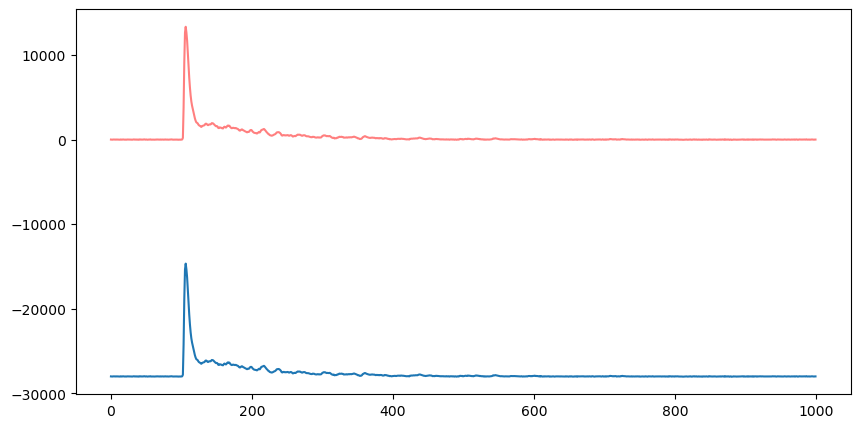

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(file['light/wvfm/data'][event]['samples'][adc,chan], alpha=1)
ax.plot(a[event, adc, chan], alpha=0.5, color='red', label='THD Corrected')

In [46]:
# now find how many waveforms there are that go above threshold
threshold = 1000
n = 0
summary = {}
light = thd_correct(file['light/wvfm/data']['samples'])
for i in range(len(file['light/wvfm/data'])):
    if np.max(light[i]) > threshold:
        n += 1
        # count how many channels are above threshold
        l = 0
        for j in range(8):
            for k in range(64):
                if np.max(light[i][j,k]) > threshold:
                    l += 1
        print(l, 'channels are above', threshold, 'in event', i)
        summary[i] = l
print(n, 'out of', len(file['light/wvfm/data']), 'events have at least one waveform that goes above', threshold)

10 channels are above 1000 in event 1
14 channels are above 1000 in event 2
3 channels are above 1000 in event 3
10 channels are above 1000 in event 4
1 channels are above 1000 in event 5
9 channels are above 1000 in event 6
12 channels are above 1000 in event 8
2 channels are above 1000 in event 9
6 channels are above 1000 in event 10
15 channels are above 1000 in event 11
2 channels are above 1000 in event 12
4 channels are above 1000 in event 13
24 channels are above 1000 in event 14
11 channels are above 1000 in event 15
15 channels are above 1000 in event 16
7 channels are above 1000 in event 17
12 channels are above 1000 in event 18
4 channels are above 1000 in event 19
11 channels are above 1000 in event 20
6 channels are above 1000 in event 21
10 channels are above 1000 in event 22
9 channels are above 1000 in event 23
7 channels are above 1000 in event 24
30 channels are above 1000 in event 25
9 channels are above 1000 in event 26
11 channels are above 1000 in event 27
5 chann

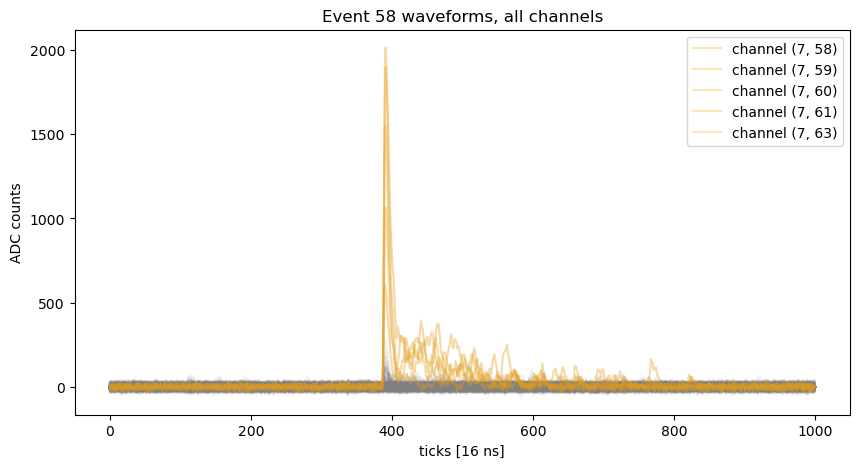

In [11]:
# for one event plot all waveforms
colors = ['r', 'b', 'c', 'm', 'y', 'g', 'k', 'orange']
event = 58
light = thd_correct(file['light/wvfm/data']['samples'])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(8):
    for j in range(64):
        ax.plot(light[event][i,j], c='grey', alpha=0.1)
        if np.max(light[event][i,j]) > 500:
            ax.plot(light[event][i,j], c=colors[i], alpha=0.3, label=f'channel {(i,j)}')
plt.xlabel('ticks [16 ns]')
plt.ylabel('ADC counts')
plt.legend()
plt.title('Event ' + str(event) + ' waveforms, all channels')
plt.show()

In [56]:
# now lets do this for some files
path = '/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/PNS_prod_V1/FLOW/'
filename = '2x2_MyQGSP_BERT_ArHP_DTG_PNS_prod_V1_{num}.FLOW.hdf5'

for i in range(0, 20):
    print('file', i)
    file = h5flow.data.H5FlowDataManager(path + filename.format(num=i), "r")
    try:
        a = file["light/wvfm/data"]['samples']
        a = thd_correct(a)
        threshold = 1000
        n = 0
        summary = {}
        for i in range(len(a)):
            if np.max(a[i]) > threshold:
                n += 1
                # count how many channels are above threshold
                l = 0
                for j in range(8):
                    for k in range(64):
                        if np.max(a[i][j,k]) > threshold:
                            l += 1
                print(l, 'channels are above', threshold, 'in event', i)
                summary[i] = l
        print(n, 'out of', len(file['light/wvfm/data']), 'events have at least one waveform that goes above', threshold)
        print('')
    except:
        print('no data')
        print('')

file 0
13 channels are above 1000 in event 0
16 channels are above 1000 in event 10
12 channels are above 1000 in event 11
7 channels are above 1000 in event 12
7 channels are above 1000 in event 13
5 channels are above 1000 in event 14
2 channels are above 1000 in event 16
6 channels are above 1000 in event 17
4 channels are above 1000 in event 18
4 channels are above 1000 in event 21
4 channels are above 1000 in event 22
1 channels are above 1000 in event 24
1 channels are above 1000 in event 26
3 channels are above 1000 in event 27
4 channels are above 1000 in event 28
6 channels are above 1000 in event 29
1 channels are above 1000 in event 30
3 channels are above 1000 in event 31
4 channels are above 1000 in event 32
16 channels are above 1000 in event 33
1 channels are above 1000 in event 35
29 channels are above 1000 in event 40
20 channels are above 1000 in event 45
1 channels are above 1000 in event 48
12 channels are above 1000 in event 49
2 channels are above 1000 in event 53

In [18]:
# Path and filenames
path = '/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/AmBe_prod_out_cryo_side_v1/FLOW/'
filename = '2x2_MyQGSP_BERT_ArHP_AmBe_AmBe_prod_out_cryo_top_mod0_v1_{num}.FLOW.hdf5'

# Trigger threshold
threshold = 1000

# To collect all dz values
dz_all = []

# Loop over files
for file_idx in range(0, 20):
    print(f'File {file_idx}')
    try:
        file = h5flow.data.H5FlowDataManager(path + filename.format(num=file_idx), "r")

        # Geometry (z of light traps)
        z_lcm = file['geometry_info/det_bounds/data']['data'][:, 0, 2]  # (129,)

        # Vertex positions
        z_verts = file['mc_truth/interactions/data']['z_vert'][:]  # (N_events,)

        for evt in range(len(file['light/wvfm/data'])):
            try:
                wvfm = thd_correct(file['light/wvfm/data']['samples'])[evt]  # shape (8, 64)
                z_vert = z_verts[evt]

                for j in range(8):
                    for k in range(64):
                        if np.max(wvfm[j, k]) > threshold:
                            ch_index = j * 64 + k

                            # Estimate which LCM this belongs to
                            trap_index = ch_index // 6

                            if trap_index >= len(z_lcm):
                                continue

                            dz = abs(z_lcm[trap_index] - z_vert)
                            dz_all.append(dz)

            except:
                continue

    except Exception as e:
        print(f'Could not open or process file {file_idx}: {e}')
        continue

# Plot result
plt.hist(dz_all, bins=100)
plt.xlim(0,60)
plt.ylim(0, 150)
plt.xlabel("z-distance between interaction and light trap [cm]")
plt.ylabel("Number of triggered channels")
# plt.title("Self-triggering vs. z-distance")
plt.grid(True)
plt.show()

File 0
File 1


In [115]:
def coord_in_tpc(x, y, z):
    if y < (-46.53 + -15.51) or y > (56.87 + 5.17):
        return -1
    if z < 0 and z > -2*31.49:
        if x < -33.5 and x > -2*33.5:
            return 8
        if x < 0 and x > -33.5:
            return 7
        if x < 33.5 and x > 0:
            return 4
        if x < 2*33.5 and x > 33.5:
            return 3
    elif z > 0 and z < 2*31.49:
        if x < -33.5 and x > -2*33.5:
            return 6
        if x < 0 and x > -33.5:
            return 5
        if x < 33.5 and x > 0:
            return 2
        if x < 2*33.5 and x > 33.5:
            return 1
    return -1  # catch all other cases (like z == 0)


In [123]:
# Count number of hits per event
from collections import Counter
path = '/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/DTG_prod_v3/FLOW/'
# path = '/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/AmBe_prod_out_cryo_side_v1/FLOW/'
filename = '2x2_MyQGSP_BERT_ArHP_PNS_DTG_prod_v3_{num}.FLOW.hdf5'
# filename = '2x2_MyQGSP_BERT_ArHP_AmBe_AmBe_prod_out_cryo_top_mod0_v1_{num}.FLOW.hdf5'

threshold = 1000
min_hits_required = 0
z_locations = np.array([-60, -1, 1, 60])  # known LCM z positions

z_distances = []
triggered = []

z_distances_per_tpc = {i: [] for i in range(1, 9)}
triggered_per_tpc = {i: [] for i in range(1, 9)}

for file_idx in range(0, 100):
    print(f'File {file_idx}')
    try:
        file = h5flow.data.H5FlowDataManager(path + filename.format(num=file_idx), "r")

        # Get all hits' event IDs
        hit_event_ids = file['charge/calib_final_hits/data']['id'][:]
        hit_counts = Counter(hit_event_ids)  # maps event_id -> hit count
        traj = file['mc_truth/trajectories/data']
        pdg_id = traj['pdg_id'][:]
        end_proc = traj['end_process'][:]
        end_subproc = traj['end_subprocess'][:]
        end_z = traj['xyz_end'][:]
        event_ids = traj['event_id'][:]

        # Find indices of captured neutrons
        is_neutron = pdg_id == 2112
        is_capture = (end_proc == 4) & (end_subproc == 131)
        is_valid = is_neutron & is_capture # 

        capture_z_per_event = {}
        for evt, z in zip(event_ids[is_valid], end_z[is_valid]):
            if evt not in capture_z_per_event:
                capture_z_per_event[evt] = z  # use first found if multiple
        print(f"{len(capture_z_per_event)} capture events found in file {file_idx}")
        # z_verts = file['mc_truth/interactions/data']['z_vert'][:]
        # z_verts = file['charge/calib_final_hits/data']['z'][:]

        data = thd_correct(file['light/wvfm/data']['samples'])

        for evt in range(len(data)):
            # try:
            if hit_counts[evt] < min_hits_required:
                continue  # skip this event if not enough hits
            if np.unique(event_ids)[evt] not in event_ids[is_valid]:
                continue  # skip if no capture
            coord = capture_z_per_event[np.unique(event_ids)[evt]]
            x, y, z = coord
            z_vert = z
            tpc = coord_in_tpc(x, y, z)
            if tpc == -1:
                continue

            nearest_z = z_locations[np.argmin(np.abs(z_locations - z))]
            dz = abs(z - nearest_z)

            wvfm = data[evt]
            event_triggered = np.any(wvfm > threshold)

            z_distances_per_tpc[tpc].append(dz)
            triggered_per_tpc[tpc].append(event_triggered)

            z_distances.append(dz)
            triggered.append(event_triggered)

                # except Exception as e:
                #     print("error:", e)
                    # continue


    except Exception as e:
        print(f'Error in file {file_idx}: {e}')
        continue

# Convert to arrays
z_distances = np.array(z_distances)
triggered = np.array(triggered)

# Bin efficiency vs. z-distance
bins = np.linspace(0, 30, 30)  # 2 cm bins up to 30 cm
bin_centers = 0.5 * (bins[:-1] + bins[1:])
efficiencies = []
num = []
denom = []
errors = []

for i in range(len(bins) - 1):
    in_bin = (z_distances >= bins[i]) & (z_distances < bins[i + 1])
    n_total = np.sum(in_bin)
    n_triggered = np.sum(triggered[in_bin])

    if n_total > 0:
        eff = n_triggered / n_total
        err = np.sqrt(eff * (1 - eff) / n_total)
    else:
        eff = 0
        err = 0

    efficiencies.append(eff)
    errors.append(err)
    num.append(n_triggered)
    denom.append(n_total)


File 0
100 capture events found in file 0
File 1
100 capture events found in file 1
File 2
101 capture events found in file 2
File 3
100 capture events found in file 3
File 4
96 capture events found in file 4
File 5
101 capture events found in file 5
File 6
101 capture events found in file 6
File 7
102 capture events found in file 7
File 8
101 capture events found in file 8
File 9
101 capture events found in file 9
File 10
100 capture events found in file 10
File 11
100 capture events found in file 11
File 12
103 capture events found in file 12
File 13
102 capture events found in file 13
File 14
98 capture events found in file 14
File 15
96 capture events found in file 15
File 16
97 capture events found in file 16
File 17
101 capture events found in file 17
File 18
102 capture events found in file 18
File 19
104 capture events found in file 19
File 20
102 capture events found in file 20
File 21
102 capture events found in file 21
File 22
102 capture events found in file 22
File 23
102 

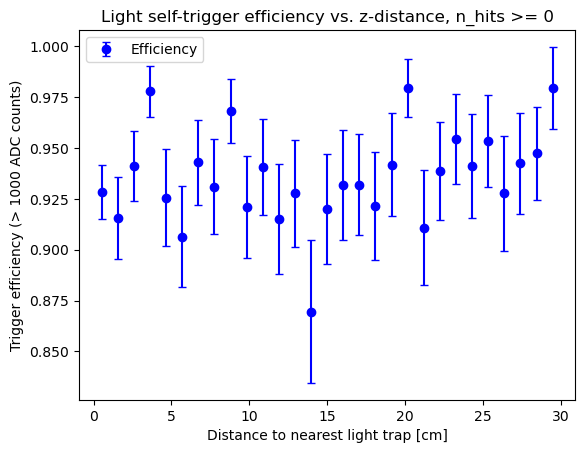

0.9795918367346939


In [124]:
plt.errorbar(bin_centers, efficiencies, yerr=errors, fmt='o', label='Efficiency', capsize=3, color='blue')
# plt.plot(bin_centers, num, marker='s', label='Triggered Events', color='red')
# plt.plot(bin_centers, denom, marker='.', label='Total Events', color='orange')
plt.xlabel("Distance to nearest light trap [cm]")
plt.ylabel("Trigger efficiency (> 1000 ADC counts)")
plt.title("Light self-trigger efficiency vs. z-distance, n_hits >= 0")
# plt.ylim(-0.02, 0.1)
plt.legend()
plt.show()

print(np.mean(eff))


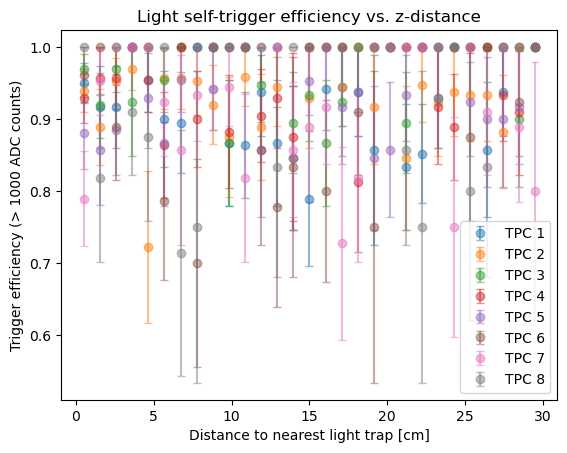

In [132]:
for tpc in range(1, 9):
    z_distances = np.array(z_distances_per_tpc[tpc])
    triggered = np.array(triggered_per_tpc[tpc])
    
    efficiencies = []
    errors = []

    for i in range(len(bins) - 1):
        in_bin = (z_distances >= bins[i]) & (z_distances < bins[i + 1])
        n_total = np.sum(in_bin)
        n_triggered = np.sum(triggered[in_bin])

        if n_total > 0:
            eff = n_triggered / n_total
            err = np.sqrt(eff * (1 - eff) / n_total)
        else:
            eff = 0
            err = 0

        efficiencies.append(eff)
        errors.append(err)

    plt.errorbar(bin_centers, efficiencies, yerr=errors, label=f'TPC {tpc}', fmt='o', capsize=3, alpha=0.5)

plt.xlabel("Distance to nearest light trap [cm]")
plt.ylabel("Trigger efficiency (> 1000 ADC counts)")
plt.title("Light self-trigger efficiency vs. z-distance")
plt.legend()
# plt.ylim(-0.05, 0.3)
plt.show()


In [37]:
capture_z_per_event.values()

dict_values([np.float32(-43.80473), np.float32(40.513927), np.float32(189.97879), np.float32(-2.6690161), np.float32(-87.93903), np.float32(-50.951492), np.float32(-36.170753), np.float32(21.392109), np.float32(-2.396278), np.float32(-1.8515534), np.float32(103.506645), np.float32(174.65741), np.float32(195.15276), np.float32(5.000098), np.float32(-22.457653), np.float32(46.010662), np.float32(36.824192), np.float32(-46.3161), np.float32(-30.361486), np.float32(-7.2517853), np.float32(-190.11697), np.float32(-2.0477262), np.float32(-41.016926), np.float32(4.357739), np.float32(185.4767), np.float32(-23.443851), np.float32(37.758404), np.float32(-187.1262), np.float32(76.25465), np.float32(-86.61605), np.float32(62.207973), np.float32(-37.975742), np.float32(48.59331), np.float32(7.875916), np.float32(65.86879), np.float32(37.473465), np.float32(-13.011522), np.float32(103.31033), np.float32(65.40912), np.float32(-33.722687), np.float32(-63.898254), np.float32(-21.77467), np.float32(-10

108


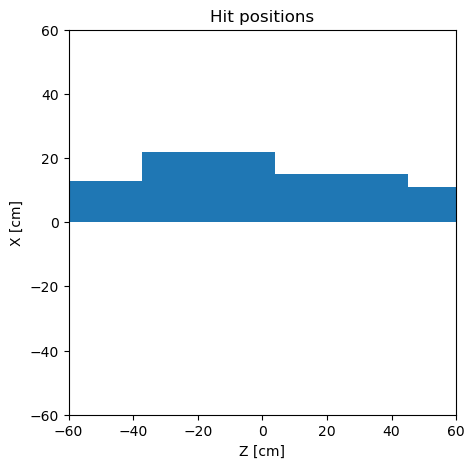

In [38]:
# let's plot vertex positions
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.scatter(file['mc_truth/interactions/data']['z_vert'], 
#            file['mc_truth/interactions/data']['y_vert'], 
#             s=10, alpha=0.2)
# ax.scatter(file['charge/calib_final_hits/data']['z'], 
#            file['charge/calib_final_hits/data']['y'], 
#             s=10, alpha=0.2) 
ax.hist(capture_z_per_event.values())
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.xlabel('Z [cm]')
plt.ylabel('X [cm]')
plt.title('Hit positions')
print(len(file['charge/events/data']))

In [11]:
# now lets do this for some files
path = '/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/PNS_prod_V1/FLOW/'
filename = '2x2_MyQGSP_BERT_ArHP_DTG_PNS_prod_V1_{num}.FLOW.hdf5'

for i in range(0, 20):
    print('file', i)
    file = h5flow.data.H5FlowDataManager(path + filename.format(num=i), "r")
    try:
        a = file["light/wvfm/data"]['samples']
        threshold = 4000
        n = 0
        summary = {}
        for i in range(len(file['light/wvfm/data'])):
            if np.max(file['light/wvfm/data'][i]['samples']) > threshold:
                n += 1
                # count how many channels are above threshold
                l = 0
                for j in range(8):
                    for k in range(64):
                        if np.max(file['light/wvfm/data'][i]['samples'][j,k]) > threshold:
                            l += 1
                print(l, 'channels are above', threshold, 'in event', i)
                summary[i] = l
        print(n, 'out of', len(file['light/wvfm/data']), 'events have at least one waveform that goes above', threshold)
        print('')
    except:
        print('no data')
        print('')

file 0


2 channels are above 4000 in event 0
2 channels are above 4000 in event 10
4 channels are above 4000 in event 12
2 channels are above 4000 in event 13
2 channels are above 4000 in event 14
1 channels are above 4000 in event 21
1 channels are above 4000 in event 32
8 channels are above 4000 in event 45
2 channels are above 4000 in event 49
2 channels are above 4000 in event 71
1 channels are above 4000 in event 85
4 channels are above 4000 in event 93
12 out of 108 events have at least one waveform that goes above 4000

file 1
2 channels are above 4000 in event 2
1 channels are above 4000 in event 6
3 channels are above 4000 in event 14
5 channels are above 4000 in event 18
4 channels are above 4000 in event 28
8 channels are above 4000 in event 30
2 channels are above 4000 in event 37
1 channels are above 4000 in event 56
2 channels are above 4000 in event 60
2 channels are above 4000 in event 69
1 channels are above 4000 in event 77
1 channels are above 4000 in event 82
2 channels are

Processing file 0
Processing file 1
Processing file 2
Processing file 3
Processing file 4
Processing file 5
Processing file 6
No data in file 6: 'Unable to synchronously open object (component not found)'
Processing file 7
Processing file 8
Processing file 9
Processing file 10
Processing file 11
Processing file 12
Processing file 13
Processing file 14
Processing file 15
Processing file 16
Processing file 17
Processing file 18
Processing file 19
Processing file 20
Processing file 21
Processing file 22
Processing file 23
Processing file 24
Processing file 25
Processing file 26
Processing file 27
Processing file 28
Processing file 29
Processing file 30
Processing file 31
Processing file 32
Processing file 33
Processing file 34
Processing file 35
Processing file 36
Processing file 37
Processing file 38
Processing file 39
Processing file 40
Processing file 41
Processing file 42
Processing file 43
Processing file 44
Processing file 45
Processing file 46
Processing file 47
Processing file 48


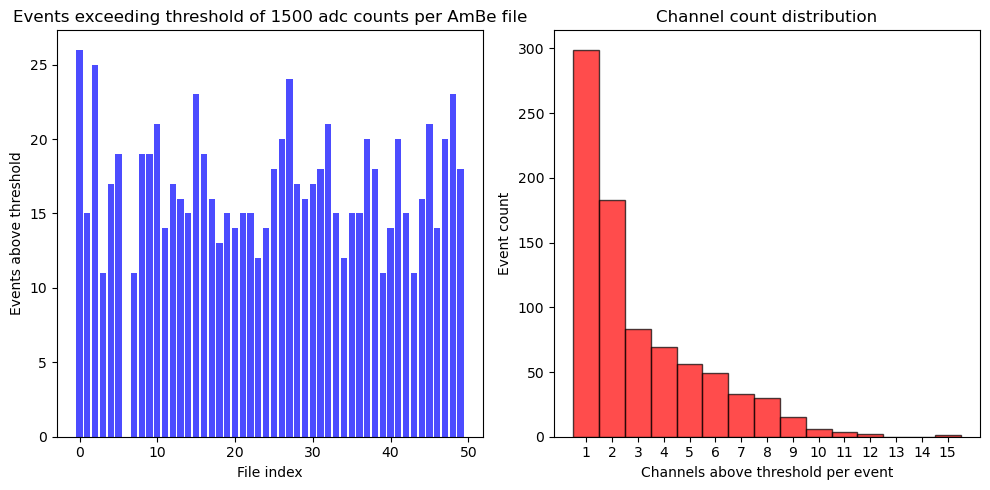


Percentage of events with at least one waveform above threshold: 18.33%


In [ ]:
# Define path and filename pattern
path = '/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/AmBe_Prod_V2/FLOW/'
filename = '2x2_MyQGSP_BERT_ArHP_AmBe_AmBe_Prod_V2_{num}.FLOW.hdf5'

# Threshold definition
threshold = 1500

# Storage for statistics
file_indices = []
num_above_threshold = []
channel_counts = []
total_events = 0
total_events_above = 0

# Process files
for i in range(50):
    print('Processing file', i)
    file = h5flow.data.H5FlowDataManager(path + filename.format(num=i), "r")
    
    try:
        data = file["light/wvfm/data"]
        num_events = len(data)
        total_events += num_events
        n_above = 0
        event_channel_counts = []

        for event_idx in range(num_events):
            samples = data[event_idx]['samples']  # Shape: (8, 64)
            
            if np.max(samples) > threshold:
                n_above += 1
                total_events_above += 1  # Count every event that exceeds threshold

                l = 0
                for j in range(8):  # Loop over 8 adcs
                    for k in range(64):  # Loop over 64 channels
                        if max(samples[j, k]) > threshold:
                            l += 1  # Count every channel that exceeds threshold
                event_channel_counts.append(l)

        # Store results
        file_indices.append(i)
        num_above_threshold.append(n_above)
        channel_counts.extend(event_channel_counts)  # Store all channel counts

    except Exception as e:
        print(f"No data in file {i}: {e}")
        file_indices.append(i)
        num_above_threshold.append(0)

# Plot results
plt.figure(figsize=(10, 5))

# Bar plot: events above threshold per file
plt.subplot(1, 2, 1)
plt.bar(file_indices, num_above_threshold, color='b', alpha=0.7)
plt.xlabel("File index")
plt.ylabel("Events above threshold")
plt.title(f"Events exceeding threshold of {threshold} adc counts per AmBe file")

# Histogram: distribution of number of channels above threshold
plt.subplot(1, 2, 2)
bins = range(1, max(channel_counts) + 2)
hist_values, bin_edges, _ = plt.hist(channel_counts, bins=bins, color='r', alpha=0.7, edgecolor='black')

# Adjust x-axis ticks to be at the center of bins
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
plt.xticks(bin_centers, labels=[str(int(c)) for c in bin_centers])  # Ensure labels are integers
plt.xlabel("Channels above threshold per event")
plt.ylabel("Event count")
plt.title("Channel count distribution")

plt.tight_layout()
plt.show()

# Compute the percentage of events exceeding threshold
if total_events > 0:
    percentage_above = (total_events_above / total_events) * 100
else:
    percentage_above = 0
print(f"\nPercentage of events with at least one waveform above threshold: {percentage_above:.2f}%")

Processing file 0


Processing file 1
Processing file 2
Processing file 3
Processing file 4
Processing file 5
Processing file 6
Processing file 7
Processing file 8
Processing file 9
Processing file 10
No data in file 10: 'Unable to synchronously open object (component not found)'
Processing file 11
Processing file 12
Processing file 13
Processing file 14
Processing file 15
Processing file 16
Processing file 17
Processing file 18
Processing file 19
Processing file 20
Processing file 21
Processing file 22
Processing file 23
Processing file 24
Processing file 25
Processing file 26
Processing file 27
Processing file 28
Processing file 29
Processing file 30
No data in file 30: 'Unable to synchronously open object (component not found)'
Processing file 31
Processing file 32
Processing file 33
Processing file 34
Processing file 35
Processing file 36
Processing file 37
Processing file 38
Processing file 39
Processing file 40
Processing file 41
Processing file 42
No data in file 42: 'Unable to synchronously open o

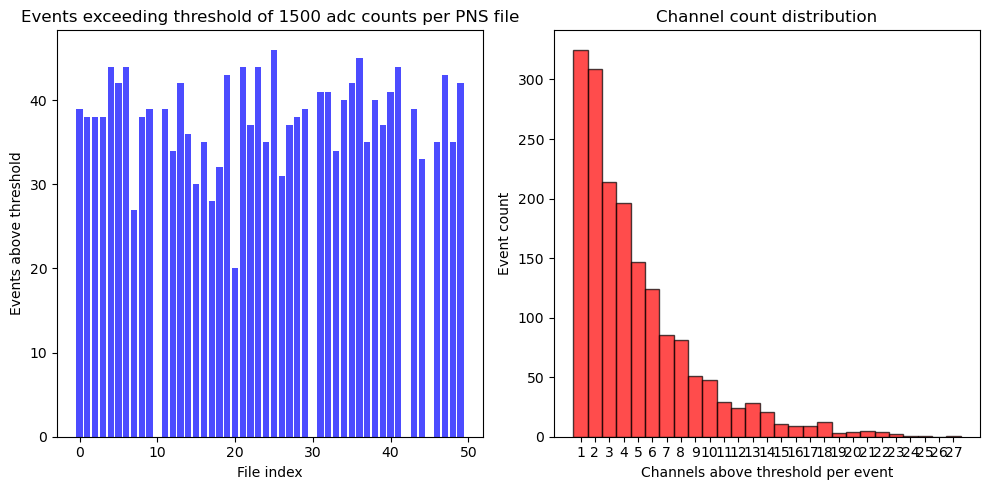


Percentage of events with at least one waveform above threshold: 38.12%


In [ ]:
# Define path and filename pattern
path = '/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/PNS_prod_V1/FLOW/'
filename = '2x2_MyQGSP_BERT_ArHP_DTG_PNS_prod_V1_{num}.FLOW.hdf5'

# Threshold definition
threshold = 1500

# Storage for statistics
file_indices = []
num_above_threshold = []
channel_counts = []
total_events = 0
total_events_above = 0

# Process files
for i in range(50):
    print('Processing file', i)
    file = h5flow.data.H5FlowDataManager(path + filename.format(num=i), "r")
    
    try:
        data = file["light/wvfm/data"]
        num_events = len(data)
        total_events += num_events
        n_above = 0
        event_channel_counts = []

        for event_idx in range(num_events):
            samples = data[event_idx]['samples']  # Shape: (8, 64)
            
            if np.max(samples) > threshold:
                n_above += 1
                total_events_above += 1
                l = 0
                for j in range(8):  # Loop over 8 adcs
                    for k in range(64):  # Loop over 64 channels
                        if max(samples[j, k]) > threshold:
                            l += 1  # Count every channel that exceeds threshold
                event_channel_counts.append(l)

        # Store results
        file_indices.append(i)
        num_above_threshold.append(n_above)
        channel_counts.extend(event_channel_counts)  # Store all channel counts




    except Exception as e:
        print(f"No data in file {i}: {e}")
        file_indices.append(i)
        num_above_threshold.append(0)

# Plot results
plt.figure(figsize=(10, 5))

# Bar plot: events above threshold per file
plt.subplot(1, 2, 1)
plt.bar(file_indices, num_above_threshold, color='b', alpha=0.7)
plt.xlabel("File index")
plt.ylabel("Events above threshold")
plt.title(f"Events exceeding threshold of {threshold} adc counts per PNS file")

# Histogram: distribution of number of channels above threshold
plt.subplot(1, 2, 2)
bins = range(1, max(channel_counts) + 2)
hist_values, bin_edges, _ = plt.hist(channel_counts, bins=bins, color='r', alpha=0.7, edgecolor='black')

# Adjust x-axis ticks to be at the center of bins
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
plt.xticks(bin_centers, labels=[str(int(c)) for c in bin_centers])  # Ensure labels are integers
plt.xlabel("Channels above threshold per event")
plt.ylabel("Event count")
plt.title("Channel count distribution")

plt.tight_layout()
plt.show()


# Compute the percentage of events exceeding threshold
if total_events > 0:
    percentage_above = (total_events_above / total_events) * 100
else:
    percentage_above = 0
print(f"\nPercentage of events with at least one waveform above threshold: {percentage_above:.2f}%")

In [ ]:
ambe_perc = {200: 92.58, 500: 85.29, 750: 50.12, 1000: 34.08, 1500: 18.33,  2000: 12.19, 3000: 6.69, 4000: 3.91, 5000: 2.54}
pns_perc = {200: 73.16, 500: 69.11, 750: 55.52, 1000: 49.60, 1500: 38.12, 2000: 30.49, 3000: 20.42, 4000: 14.05, 5000: 9.75}

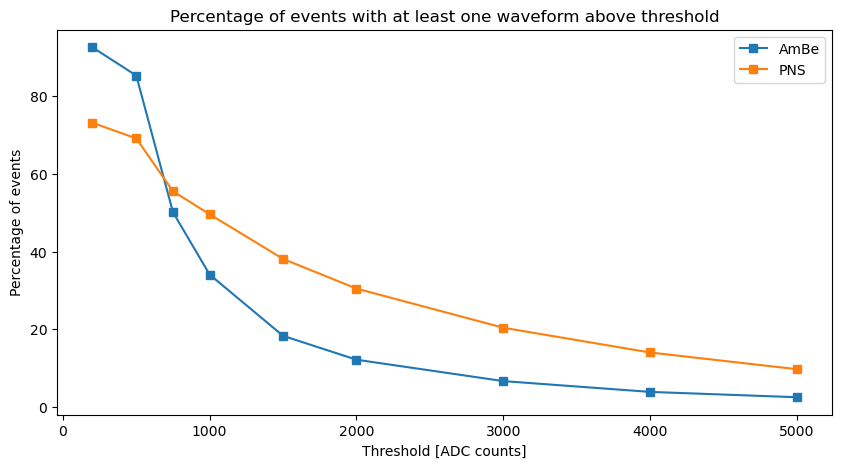

In [ ]:
# plot the percentates
plt.figure(figsize=(10, 5))
plt.plot(list(ambe_perc.keys()), list(ambe_perc.values()), marker='s', label='AmBe')
plt.plot(list(pns_perc.keys()), list(pns_perc.values()), marker='s', label='PNS')
plt.xlabel('Threshold [ADC counts]')
plt.ylabel('Percentage of events')
plt.title('Percentage of events with at least one waveform above threshold')
plt.legend()
plt.show()